# Evaluation of Graph Neural Network segment classifier

In [1]:
%pwd

'/global/u2/s/sfarrell/WorkAreas/trackml/heptrkx-gnn-tracking/notebooks'

In [2]:
# System imports
import os
import sys

# External imports
import matplotlib.pyplot as plt
import numpy as np

# Limit CPU usage on Jupyter
os.environ['OMP_NUM_THREADS'] = '4'

# Pick up local packages
sys.path.append('..')

# Local imports
from trainers import get_trainer
from nb_utils import (get_test_data_loader, load_config, load_summaries,
                      plot_train_history, compute_metrics, plot_metrics,
                      draw_sample_xy)

In [3]:
# Config path
config_file = '../configs/mpnn.yaml'

In [4]:
!cat $config_file

output_dir: ${SCRATCH}/heptrkx/results/mpnn_001

trainer:
    name: gnn_sparse

data:
    name: hitgraphs_sparse
    input_dir: ${SCRATCH}/heptrkx/data/hitgraphs_high_000
    n_train: 49152 #57344
    n_valid: 4096
    real_weight: 5 #6.25  # 0.5 / 0.08
    batch_size: 4
    n_workers: 4

model:
    name: mpnn
    input_dim: 3
    hidden_node_dim: 64
    hidden_edge_dim: 64
    n_graph_iters: 8
    layer_norm: true
    loss_func: binary_cross_entropy_with_logits

optimizer:
    name: Adam
    learning_rate: 0.001
    lr_scaling: sqrt
    lr_warmup_epochs: 5
    lr_decay_schedule:
        - {start_epoch: 16, end_epoch: 32, factor: 0.1}
        - {start_epoch: 32, end_epoch: 64, factor: 0.01}

training:
    n_epochs: 64


In [5]:
config = load_config(config_file)
summaries = load_summaries(config)

In [6]:
summaries

,lr,train_loss,epoch,train_time,valid_loss,valid_acc,valid_time
0,0.00100,0.298061,0,2519.074478,0.206325,0.900549,104.738376
1,0.00100,0.155043,1,2517.704575,0.131519,0.946746,104.878865
2,0.00100,0.125819,2,2516.073753,0.112970,0.956756,104.755186
3,0.00100,0.115648,3,2538.351788,0.114282,0.955689,104.750780
4,0.00100,0.108011,4,2516.993619,0.099701,0.962151,104.630954
...,...,...,...,...,...,...,...
59,0.00001,0.082894,59,2518.616920,0.077549,0.973201,104.505327
60,0.00001,0.082887,60,2523.282559,0.077175,0.973473,104.601786
61,0.00001,0.082823,61,2516.438203,0.075827,0.973934,104.194880
62,0.00001,0.082767,62,2515.576709,0.075997,0.973745,104.734182


## Plot the Training loss and accuracy

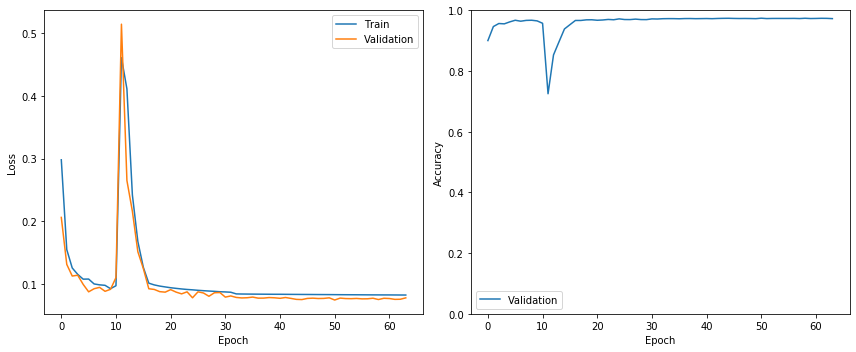

In [7]:
plot_train_history(summaries)

## Load the trained model

In [8]:
# Find the best epoch
best_idx = summaries.valid_loss.idxmin()
summaries.loc[[best_idx]]

,lr,train_loss,epoch,train_time,valid_loss,valid_acc,valid_time
50,0.00001,0.083333,50,2519.520472,0.074798,0.97429,104.663845


In [9]:
# Build the trainer and load best checkpoint
trainer = get_trainer(output_dir=config['output_dir'], **config['trainer'])
trainer.build_model(optimizer_config=config['optimizer'], **config['model'])

best_epoch = summaries.epoch.loc[best_idx]
trainer.load_checkpoint(checkpoint_id=best_epoch)

print(trainer.model)
print('Parameters:', sum(p.numel() for p in trainer.model.parameters()))

GNN(
  (node_encoder): Sequential(
    (0): Linear(in_features=3, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
  )
  (edge_network): Sequential(
    (0): Linear(in_features=134, out_features=64, bias=True)
    (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (8): ReLU()
    (9): Linear(in_features=64, out_features=64, bias=True)
    (10): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (11): ReLU()
  )
  (node_network): Sequential(
    (0): Linear(in_features=131, out_features=64, bias=True)
    (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=64, bia

## Load the test data set and evaluate the model

In [10]:
n_test = 64
test_loader = get_test_data_loader(config, n_test=n_test)

In [11]:
%%time
test_preds, test_targets = trainer.predict(test_loader)

CPU times: user 1min 34s, sys: 4.48 s, total: 1min 39s
Wall time: 24.8 s


In [12]:
threshold = 0.5
test_metrics = compute_metrics(test_preds, test_targets, threshold=threshold)

print('Test set results with threshold of', threshold)
print('Accuracy:  %.4f' % test_metrics.accuracy)
print('Precision: %.4f' % test_metrics.precision)
print('Recall:    %.4f' % test_metrics.recall)

Test set results with threshold of 0.5
Accuracy:  0.9741
Precision: 0.7546
Recall:    0.9487


In [13]:
threshold = 0.8
test_metrics = compute_metrics(test_preds, test_targets, threshold=threshold)

print('Test set results with threshold of', threshold)
print('Accuracy:  %.4f' % test_metrics.accuracy)
print('Precision: %.4f' % test_metrics.precision)
print('Recall:    %.4f' % test_metrics.recall)

Test set results with threshold of 0.8
Accuracy:  0.9838
Precision: 0.8727
Recall:    0.9070


In [14]:
threshold = 0.9
test_metrics = compute_metrics(test_preds, test_targets, threshold=threshold)

print('Test set results with threshold of', threshold)
print('Accuracy:  %.4f' % test_metrics.accuracy)
print('Precision: %.4f' % test_metrics.precision)
print('Recall:    %.4f' % test_metrics.recall)

Test set results with threshold of 0.9
Accuracy:  0.9849
Precision: 0.9280
Recall:    0.8568


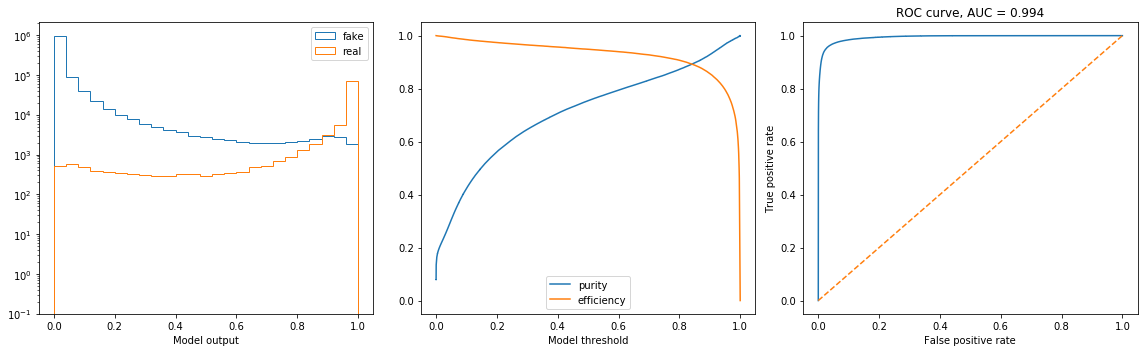

In [15]:
plot_metrics(test_preds, test_targets, test_metrics)

## Visualize predictions

In [16]:
n_phi_sections = 8
feature_scale = np.array([1000., np.pi / n_phi_sections, 1000.])

In [17]:
i = 0

g = test_loader.dataset[i]
e = g.edge_index.numpy()
x = g.x.numpy() * feature_scale
y = g.y.numpy()
o = test_preds[i].numpy()

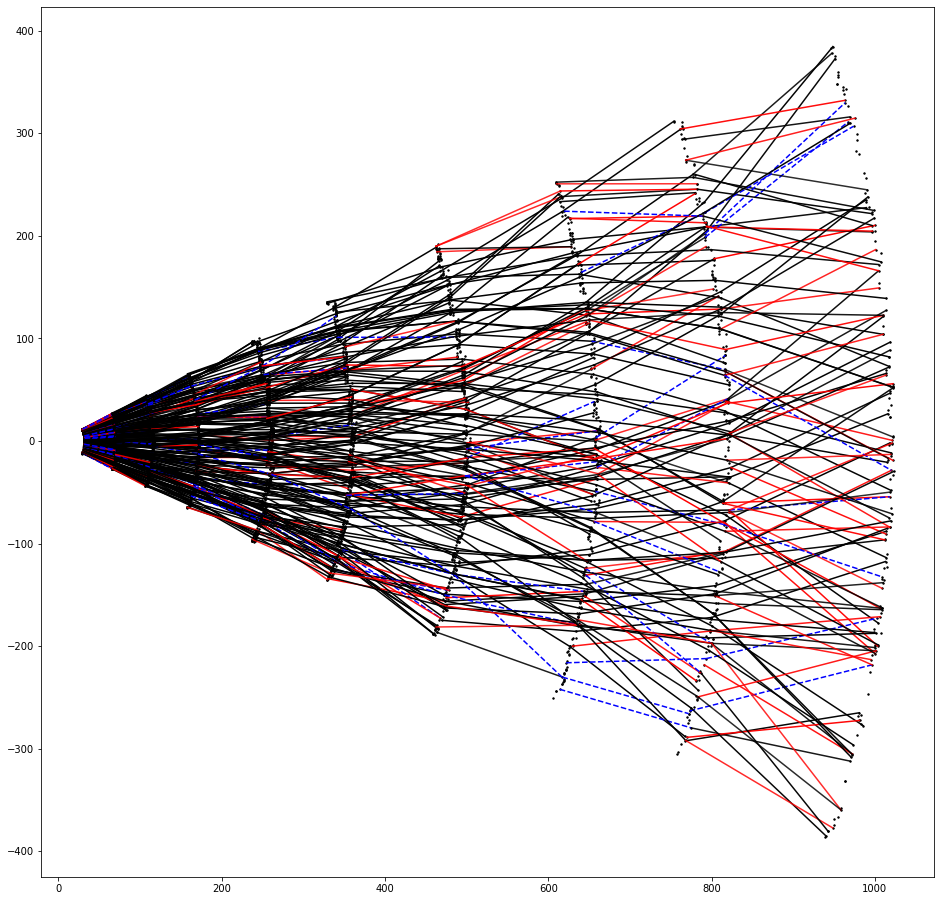

In [18]:
draw_sample_xy(x, e, o, y, cut=0.8);